# Backtrader

官方文档：https://www.backtrader.com/docu

中文解读：https://blog.csdn.net/h00cker/category_11448348.html

可以先看看中文解读，搞清楚每个框架大概是干什么的，再去官方文档里看细节

优点：数据接口多(可以直接接Tushare)，容易上手，功能完善（尤其是参数调优功能），社区活跃...

缺点：对tick级别回测效果一般(一般是撮合制回测引擎，不在本项目的讨论范围内，倒也没那么强的数据），近几年的维护做的一般

使用它是因为它的功能足以支持本项目要复现的经典策略（从头造轮子真的很麻烦，而用backtrader只需要搞清楚交易逻辑就好了,这之后的参数调优、指标分析只用调用下内置的类就好，很方便）

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import backtrader as bt
from datetime import datetime

In [2]:
from backtrader.feeds import PandasData

# 数据

支持雅虎、tushare等数据源


如果使用pandas dataframe格式 要注意数据次序

In [3]:
df = pd.read_csv('./data/example.csv')
df['open_time'] = pd.to_datetime(df.open_time)
df = df.set_index('open_time')

#日内指标
high = df.resample('1D')['high'].max()
low = df.resample('1D')['low'].min()
close = df.resample('1D')['close'].last()
pivot = (high+low+close)/3
price_range = high - low
p = pivot
r= price_range

#获取price_range pivot
bins = list(r.index[1:])
bins.append(r.index[-1]+np.timedelta64(1,'D'))
labels = r.values[1:]
df['price_range'] = pd.cut(df.index,bins = bins,labels = labels,ordered = False,right = True).astype('float')

bins = list(p.index[1:])
bins.append(p.index[-1]+np.timedelta64(1,'D'))
labels = p.values[1:]
df['pivot'] = pd.cut(df.index,bins = bins,labels = labels,ordered = False,right = True).astype('float')   

In [4]:
df['open_time'] = df.index
df

,open,high,low,close,volume,price_range,pivot,open_time
open_time,,,,,,,,
2019-10-01 00:00:00,8284.87,8286.05,8238.01,8242.33,219.186121,NaN,NaN,2019-10-01 00:00:00
2019-10-01 00:05:00,8241.55,8249.79,8230.03,8234.22,164.891499,NaN,NaN,2019-10-01 00:05:00
2019-10-01 00:10:00,8235.52,8245.07,8206.57,8243.39,175.031226,NaN,NaN,2019-10-01 00:10:00
2019-10-01 00:15:00,8242.94,8252.53,8235.18,8242.69,93.312935,NaN,NaN,2019-10-01 00:15:00
2019-10-01 00:20:00,8239.17,8239.31,8210.01,8219.42,163.807780,NaN,NaN,2019-10-01 00:20:00
...,...,...,...,...,...,...,...,...
2020-10-31 23:35:00,13790.01,13804.72,13788.95,13801.54,70.406281,688.5,13767.5,2020-10-31 23:35:00
2020-10-31 23:40:00,13801.54,13807.30,13793.57,13807.30,66.578222,688.5,13767.5,2020-10-31 23:40:00
2020-10-31 23:45:00,13807.31,13824.13,13803.39,13807.20,112.175432,688.5,13767.5,2020-10-31 23:45:00


In [5]:
#PandasData是只支持high low volume open close这五条数据的，继承这个class并加入新的数据名就好，比方说这里要加pivot和price_range
class PandasData1(PandasData):
    lines = ('pivot','price_range')
    params = (
        ('pivot', 7),
        ('price_range',6)
    )


In [6]:
start=datetime(2019, 10, 31)
end=datetime(2020, 10, 31)
feeds = PandasData1(
        dataname=df,
        datetime=7,  # 日期行所在列
        open=1-1,  # 开盘价所在列
        high=2-1,  # 最高价所在列
        low=3-1,  # 最低价所在列           ————注意要和我们输入的dataframe是对应的
        close=4-1,  # 收盘价价所在列
        volume=5-1,  # 成交量所在列
        openinterest=-1,  # 无未平仓量列.(openinterest是期货交易使用的)
        fromdate=start,  # 起始日
        todate=end,
        price_range=6-1,  # 新定义 换手率线 的索引
        pivot = 7-1
    )

# 策略

In [8]:
#策略
class R_breaker(bt.Strategy):
    #全局设定交易策略的参数(参数调优)
    params=(('k1',0.5),
            ('k2',0.1),
            ('size',1),
           )
    
    
    #计算指标
    def __init__(self):
        
        self.pivot = self.datas[0].pivot
        self.price_range = self.datas[0].price_range   
        self.open = self.datas[0].open
        # 初始化交易指令、买卖价格和手续费
        self.order = None
        
        
    #核心：交易逻辑
    def next(self):
        # 检查是否持仓   
        if self.position.size == 0: # 没有持仓
            #突破r3
            if self.open[0] > self.pivot[0] + self.params.k2*self.price_range[0]:
                #开多
                self.order = self.buy(size=self.params.size) 
            #跌破r1
            if self.open[0] < self.pivot[0] + self.params.k1*self.price_range[0]:
                #开空
                self.order = self.sell(size = self.params.size)
        if self.position.size > 0 :
            if self.open[0] > self.pivot[0] - self.params.k2*self.price_range[0]:
                #反转开空
                self.order = self.close()
                self.order = self.sell(size = self.params.size)
        if self.position.size < 0 :
            if self.open[0] < self.pivot[0] - self.params.k1*self.price_range[0]:
                self.order = self.close()
                self.order = self.buy(size = self.params.size)

# 回测

In [9]:
#回测
# 初始化cerebro回测系统设置                           
cerebro = bt.Cerebro()  
#将数据传入回测系统
cerebro.adddata(feeds) 
# 将交易策略加载到回测系统中
cerebro.addstrategy(R_breaker) 
# 设置初始资本为10,000
startcash = 10000
cerebro.broker.setcash(startcash) 
# 设置交易手续费为 0.2%
cerebro.broker.setcommission(commission=0.002) 
# 设置交易滑点为2%
cerebro.broker.set_slippage_perc(0.02)
d1=start.strftime('%Y-%m-%d')
d2=end.strftime('%Y-%m-%d')
print(f'初始资金: {startcash}\n回测期间：{d1}:{d2}')
#运行回测系统
analyzer_data = cerebro.run()
#获取回测结束后的总资金
portvalue = cerebro.broker.getvalue()
pnl = portvalue - startcash
#打印结果
print(f'总资金: {round(portvalue,2)}')

# 初始资金: 10000
# 回测期间：20100331:20200331
# 总资金: 12065.36
# 净收益: 2065.36

初始资金: 10000
回测期间：2019-10-31:2020-10-31
总资金: 41716.13


<IPython.core.display.Javascript object>


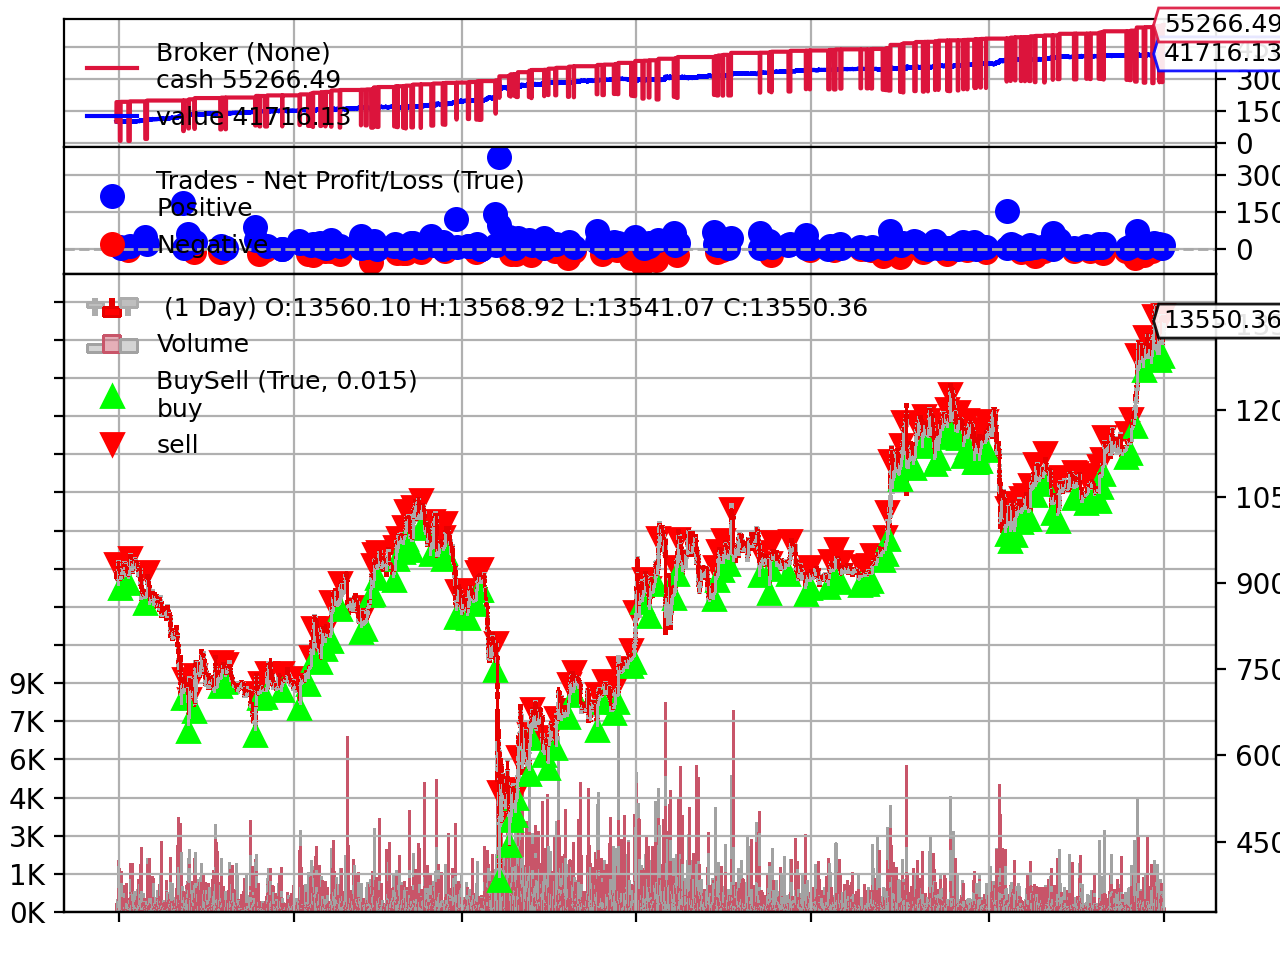

[[<Figure size 640x480 with 4 Axes>]]

In [10]:
%matplotlib inline 
cerebro.plot(style='candlestick')

# 分析:analyzers

In [22]:
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='AnnualReturn')
cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.003, annualize=True, _name='SharpeRatio')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='DrawDown')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='TradeAnalyzer')
# strats = cerebro.run()
# strat = strats[0]
print(" AnnualReturn:")
print(strat.analyzers.AnnualReturn.get_analysis())
print("SharpeRatio:")
print(strat.analyzers.SharpeRatio.get_analysis())
print("DrawDown:")
print(strat.analyzers.DrawDown.get_analysis())
print("TradeAnalyzer:")
print(strat.analyzers.TradeAnalyzer.get_analysis().items())


 AnnualReturn:
OrderedDict([(2019, 0.5104780619999993), (2020, 1.761783371389344)])
SharpeRatio:
OrderedDict([('sharperatio', 1.8111178913604324)])
DrawDown:
AutoOrderedDict([('len', 107), ('drawdown', 0.46702767194694894), ('moneydown', 195.74003999999695), ('max', AutoOrderedDict([('len', 3140), ('drawdown', 4.5813187317378725), ('moneydown', 1329.6382799999992)]))])
TradeAnalyzer:
odict_items([('total', AutoOrderedDict([('total', 243), ('open', 1), ('closed', 242)])), ('streak', AutoOrderedDict([('won', AutoOrderedDict([('current', 5), ('longest', 9)])), ('lost', AutoOrderedDict([('current', 0), ('longest', 3)]))])), ('pnl', AutoOrderedDict([('gross', AutoOrderedDict([('total', 40830.817600000046), ('average', 168.7223867768597)])), ('net', AutoOrderedDict([('total', 31883.301964800026), ('average', 131.7491816727274)]))])), ('won', AutoOrderedDict([('total', 174), ('pnl', AutoOrderedDict([('total', 41588.028902000005), ('average', 239.01166035632187), ('max', 3695.3842000000004)]))

# 参数调优：optstrategy

In [ ]:
cerebro.optstrategy(
            R_breaker,
            k1 = range(1,5),
            k2 = range(1,2),
            size = range(1,2))
            
    
back = cerebro.run()
back

# # 每个策略实例的结果以列表的形式保存在列表中。
# # 优化运行模式下，返回值是列表的列表,内列表只含一个元素，即策略实例
# par_list = [[x[0].params.k1, 
#             x[0].params.k2,
#             x[0].analyzers.DrawDown.get_analysis()['max']['drawdown'],
#             x[0].analyzers.SharpeRatio.get_analysis()['sharperatio']
#             ] for x in back]

# # 结果转成dataframe
# par_df = pd.DataFrame(par_list, columns = ['k1', 'k2', 'return', 'dd', 'sharpe'])

# print(par_df.head())
